# Image Captioning

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.


# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# Fix to work on colab
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 124.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 125.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision.transforms.functional as TF

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:27<00:00, 43.9MB/s]
100% 1.04G/1.04G [00:27<00:00, 40.0MB/s]


In [ ]:
!unzip flickr8k.zip -d flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [4]:
import os
import pandas as pd
import spacy
import torch
from PIL import Image
import spacy
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

spacy_eng = spacy.load("en_core_web_sm")
class Vocabulary:
    def __init__(self, freq_threshold):
        # if a word is not repeated at least as the number of freq_threshold it will be set as unknown
        # PAD is used to Uniform Sequence Lengths
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
      # getting the length of our vocabulary
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
      # this will allows to u to tokenize the sentence which mean split it : Hello My Friend => ["Hello", "My", "Friend"]
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        # counting the occurence of each word if the occurence is at least equal to threshold I accpeted if not ignore it
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
      # converting text to numerical values:
      #1- tokenize the text
        tokenized_text = self.tokenizer_eng(text)
        # 2- check if each token(word)from the tokenized list is in the vocab dictionary of strings
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5): #generous hint
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Geting img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_id = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_id)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption) #generous hint


class MyCollate:
  # checking the maximum length of a sequence in our batch and pad the other sequence length to this one.
  # Because all of them must have the same length in our batch.
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    # the list of all examples
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)
    # captions
    targets = [item[1] for item in batch]
    # pads the list of target length sequences to the same length.
    targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

    return imgs, targets


def get_loader(root_folder, annotation_file, transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx)
    )

    return loader, dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
   # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize based on ImageNet statistics
                       #  std=[0.229, 0.224, 0.225])
])


In [5]:
dataloader = get_loader("/content/drive/MyDrive/flickr8k/Images", "/content/drive/MyDrive/flickr8k/captions.txt", transform=transform)
for idx, (imgs, captions) in enumerate(dataloader[0]):
    print(imgs.shape)
    print(captions.shape)
    if idx == 3:
        break


torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
torch.Size([32, 3, 224, 224])
torch.Size([32, 26])
torch.Size([32, 3, 224, 224])
torch.Size([32, 30])
torch.Size([32, 3, 224, 224])
torch.Size([32, 21])


Example output from dataset class

Dataset size: 40455


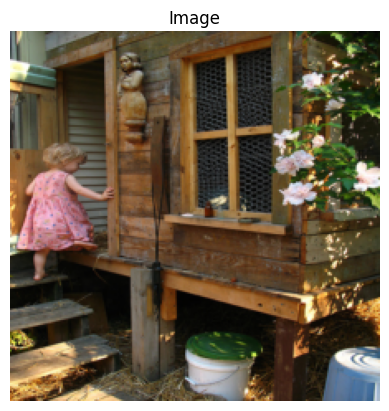

Token: tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [6]:
import matplotlib.pyplot as plt
import numpy as np
# Show some visualizations of the created dataset
def show_image(img, title):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
dataset = dataloader[1]
print("Dataset size:", len(dataset))
img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

Split your dataset into train, val and test sets

In [ ]:
# ADD YOUR CODE HERE
import torch
from torch.utils.data import random_split

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - (train_size + val_size)

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

train_data, val_data, test_data = split_dataset(dataset)
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 32364
Validation size: 4045
Test size: 4046


Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

In [ ]:
import torch


# Save the datasets to files
torch.save(train_data, '/content/drive/MyDrive/train_data.pth')
torch.save(val_data, '/content/drive/MyDrive/val_data.pth')
torch.save(test_data, '/content/drive/MyDrive/test_data.pth')

print("Datasets saved successfully!")


In [7]:
import torch

# Load the datasets from files
train_data = torch.load('/content/drive/MyDrive/train_data.pth')
val_data = torch.load('/content/drive/MyDrive/val_data.pth')
test_data = torch.load('/content/drive/MyDrive/test_data.pth')

print("Datasets loaded successfully!")


Datasets loaded successfully!


In [8]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]))
val_loader = DataLoader(val_data, batch_size=32, collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]))
test_loader = DataLoader(test_data, batch_size=32, collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]))

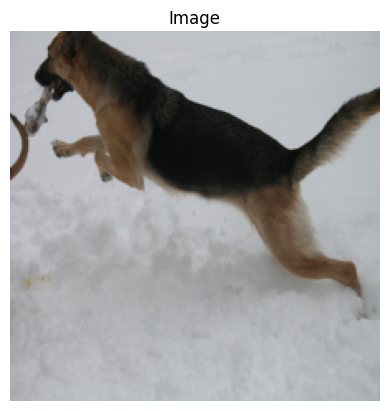

Token: tensor([  1,  20,  16, 194,   6,  12, 354,   8,  62,   8,  10,  31,   5,   2])
Sentence:
['<SOS>', 'black', 'and', 'tan', 'dog', 'with', 'object', 'in', 'mouth', 'in', 'the', 'snow', '.', '<EOS>']


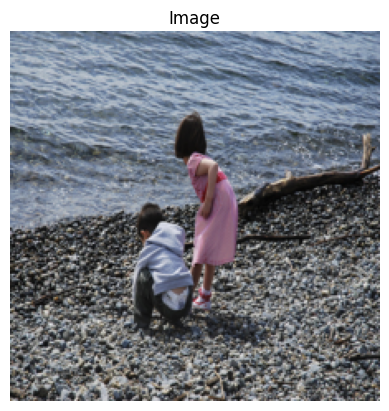

Token: tensor([  1,  50,   9, 258,  98,  13,   4,   3, 114,  52,   5,   2])
Sentence:
['<SOS>', 'two', 'little', 'kids', 'play', 'on', 'a', '<UNK>', 'covered', 'beach', '.', '<EOS>']


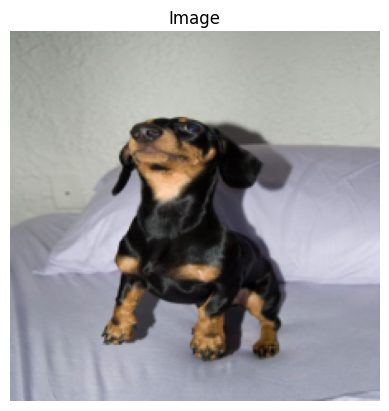

Token: tensor([   1,    4, 2214,  564,  118,   13,    4,  213,    5,    2])
Sentence:
['<SOS>', 'a', 'dachshund', 'puppy', 'jumps', 'on', 'a', 'bed', '.', '<EOS>']


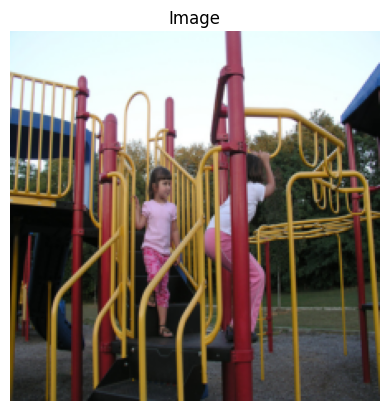

Token: tensor([  1,  50,   9, 237,   8, 195,  34,   8,   4, 290,   5,   2])
Sentence:
['<SOS>', 'two', 'little', 'girls', 'in', 'pink', 'are', 'in', 'a', 'playground', '.', '<EOS>']


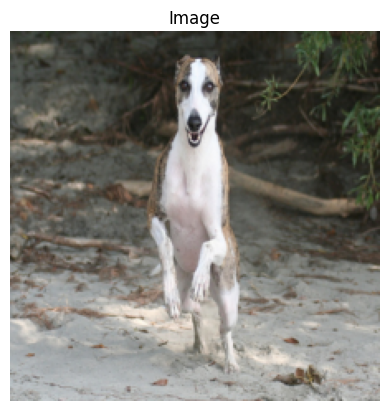

Token: tensor([  1,   6,  29,  13,  50, 608,   2])
Sentence:
['<SOS>', 'dog', 'running', 'on', 'two', 'legs', '<EOS>']


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(img, title):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

for i in range(5):
  img, caps = train_data[i]
  show_image(img,"Image")
  print("Token:",caps)
  print("Sentence:")
  print([dataset.vocab.itos[token] for token in caps.tolist()])

#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [10]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


## Encoder

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import models
class ResNetEncoder(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.output_channels = 2048

        self.conv_reshape = nn.Conv2d(self.output_channels, d_model, kernel_size=1)

        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.resnet(x)

        features = self.conv_reshape(features)

        batch_size, d_model, h, w = features.size()
        features = features.permute(0, 2, 3, 1)  # (batch_size, h, w, d_model)
        features = features.view(batch_size, h * w, d_model)  # (batch_size, sequence_length, d_model)

        return features

## Multihead Attention

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, V)

        return output, attn_weights

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        Q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attn_weights


## Positional

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super().__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Decoder Layer

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # Self attention
        attn_output, self_attn_weights = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Cross attention
        attn_output, cross_attn_weights = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x, self_attn_weights, cross_attn_weights


## Decoder

In [15]:
class ImageCaptioningDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None):
        # Embed tokens and add positional encoding
        x = self.embedding(tgt) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        self_attentions = []
        cross_attentions = []

        for layer in self.layers:
            x, self_attn, cross_attn = layer(x, memory, tgt_mask=tgt_mask)
            self_attentions.append(self_attn)
            cross_attentions.append(cross_attn)

        output = self.fc_out(x)
        return output, self_attentions, cross_attentions


## Combine the encoder - attention - decoder



In [16]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1):
        super().__init__()

        self.encoder = ResNetEncoder(d_model)
        self.decoder = ImageCaptioningDecoder(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

    def forward(self, images, captions, caption_mask=None):
        # Encode images
        encoded_images = self.encoder(images)  # (batch_size, sequence_length, d_model)

        # Decode captions
        output, self_attentions, cross_attentions = self.decoder(captions, encoded_images, tgt_mask=caption_mask)

        return output, self_attentions, cross_attentions

In [17]:
embed_size = 256
vocab_size = 5000
num_heads = 8
num_layers = 6
max_seq_length = 50
d_ff = 1024  # Feed-forward dimension


model = ImageCaptioningModel(vocab_size, embed_size, num_heads, num_layers,d_ff, max_seq_length)

# Dummy input
images = torch.randn(8, 3, 224, 224)  # Batch of 8 images
captions = torch.randint(0, vocab_size, (8, max_seq_length))  # Batch of captions

# Forward pass
outputs, self_attentions, cross_attentions = model(images, captions)
print(outputs.shape)
print(len(self_attentions))
print(len(cross_attentions))
print(cross_attentions[0].shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


torch.Size([8, 50, 5000])
6
6
torch.Size([8, 8, 50, 49])


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

Epoch [1/10], Train Loss: 3.8186, Val Loss: 2.9111
Epoch [3/10], Train Loss: 2.1268, Val Loss: 1.9723
Epoch [4/10], Train Loss: 1.8214, Val Loss: 1.7342
Epoch [5/10], Train Loss: 1.5979, Val Loss: 1.5754
Epoch [6/10], Train Loss: 1.4213, Val Loss: 1.4486
Epoch [7/10], Train Loss: 1.2785, Val Loss: 1.3522
Epoch [8/10], Train Loss: 1.1553, Val Loss: 1.2767
Epoch [9/10], Train Loss: 1.0542, Val Loss: 1.2325
Epoch [10/10], Train Loss: 0.9678, Val Loss: 1.1871
Model saved to /content/drive/MyDrive/image_captioning_final.pth


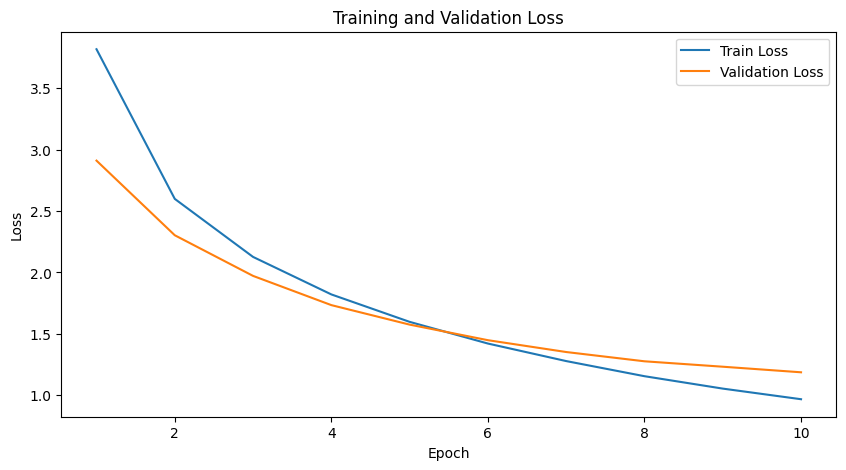

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define Hyperparameters
embed_size = 256
vocab_size = 5000  # len(dataset.vocab)
num_heads = 8
num_layers = 3
max_seq_length = 50
dropout = 0.1
learning_rate = 1e-4
num_epochs = 10
d_ff = 1024
d_model = 256  # This is the model dimension (d_model for ResNet Encoder)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = ImageCaptioningModel(vocab_size=vocab_size, d_model=d_model, num_heads=num_heads,
                             num_layers=num_layers, d_ff=d_ff, max_seq_length=max_seq_length, dropout=dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Function to save the model
def save_model(model, num_epochs, filename='/content/drive/MyDrive/image_captioning.pth'):
    torch.save({
        'embed_size': embed_size,
        'vocab_size': vocab_size,
        'num_heads': num_heads,
        'num_layers': num_layers,
        'max_seq_length': max_seq_length,
        'dropout': dropout,
        'state_dict': model.state_dict()
    }, filename)
    print(f"Model saved to {filename}")


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0
        model.train()
        for images, captions in train_loader:
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs, _, _ = model(images, captions[:, :-1])  # Exclude <EOS> for inputs
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))  # Shift for <SOS>

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images = images.to(device)
                captions = captions.to(device)
                outputs, _, _ = model(images, captions[:, :-1])  # Exclude <EOS> for inputs
                loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))  # Shift for <SOS>
                epoch_val_loss += loss.item()

        # Record losses
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(epoch_val_loss / len(val_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Save the model after training
    save_model(model, num_epochs, '/content/drive/MyDrive/image_captioning_final.pth')

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    torch.save(model, '/content/drive/MyDrive/image_captioning_model_full.pth')
    return model


# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Save the trained model
torch.save(trained_model, '/content/drive/MyDrive/image_captioning_model_full1.pt')


Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('/content/drive/MyDrive/image_captioning_model_full1.pt', map_location=device)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

def visualize_attention(image, caption, attention_weights, word_idx=None):

    # Normalize attention weights to a [0, 1] range
    attn_weights = attention_weights.squeeze().cpu().detach().numpy()

    if word_idx is not None:
        attn_map = attn_weights[word_idx]
    else:
        # Visualize the overall attention (mean across all words)
        attn_map = attn_weights.mean(axis=0)

    # Compute feature map dimensions dynamically
    total_elements = attn_map.size
    feature_map_height = 8  # Use model's known output feature height
    feature_map_width = total_elements // feature_map_height
    assert total_elements == feature_map_height * feature_map_width, \

    attn_map = attn_map.reshape(feature_map_height, feature_map_width)

    # Resize attention map to match the input image dimensions
    img_height, img_width = image.shape[1], image.shape[2]


    # Plot the original image
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    # Overlay the attention map (blocky look)
    ax.imshow(attn_map, cmap='gray', alpha=0.7, extent=(0, image.shape[2], image.shape[1], 0), interpolation='nearest')  # No interpolation

    # Annotate with the caption words
    if word_idx is not None:
        wordstring = caption[word_idx].item()
        ax.set_title(f"Attention for word: {train_data.dataset.vocab.itos[wordstring]}")
    else:
        ax.set_title("Average Attention across all words")

    plt.axis('off')
    plt.show()



Image: height:224, width:224
Cross Attention: height:8, width:21


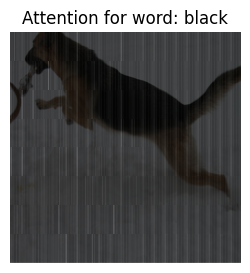

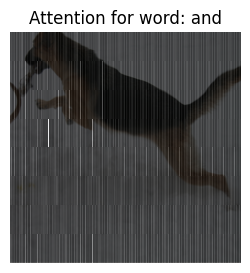

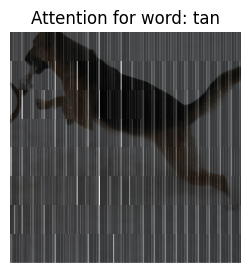

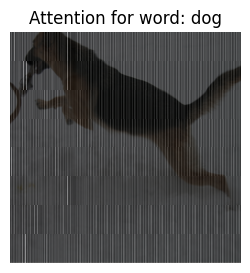

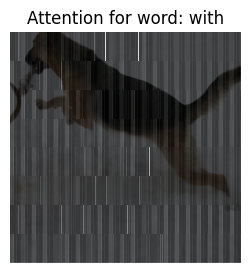

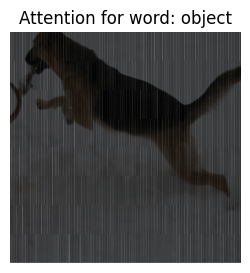

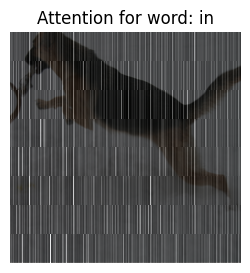

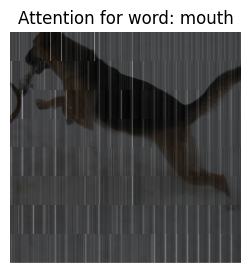

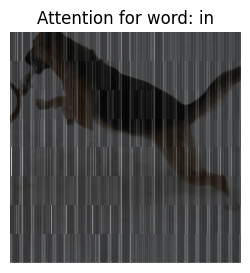

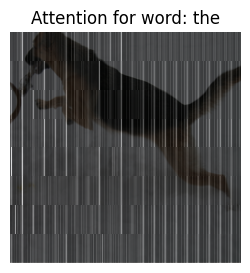

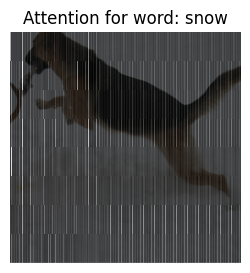

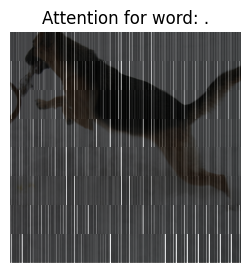

In [ ]:
# Initialize AttentionVisualizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Loop through train_data_loader
for batch_idx, (images, captions) in enumerate(train_loader):
    images = images.to(device)
    captions = captions.to(device)
    output, self_attentions, cross_attentions = model(images, captions)  # Forward pass
    image_path = images[0]
    caption = captions[0]
    break

print(f'Image: height:{image_path.shape[1]}, width:{image_path.shape[2]}')
print(f'Cross Attention: height:{cross_attentions[0].shape[1]}, width:{cross_attentions[0].shape[2]}')
for i in range(len(caption)-1):
  if caption[i+1].item() != 2 and caption[i+1].item() != 0:
    visualize_attention(image_path, caption, cross_attentions[0], word_idx=i+1)
  else:
    break


### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [ ]:
from torchtext.data.metrics import bleu_score
import torch

def evaluate_model_with_bleu(model, test_loader, device='cpu', max_n=3):
    model.eval()
    all_references = []
    all_predictions = []

    with torch.no_grad():
        for images, captions in test_loader:
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass: get the predicted captions
            outputs, _, _ = model(images, captions[:, :-1])  # Exclude <EOS> for inputs

            # Decode the predicted captions
            predicted_captions = torch.argmax(outputs, dim=2)

            for i in range(len(predicted_captions)):
                # Convert predicted caption (tensor) to list of words
                predicted_caption = predicted_captions[i].cpu().numpy().tolist()
                decoded_predicted_caption = [dataset.vocab.itos[token] for token in predicted_caption]

                # Remove padding and <EOS> tokens
                decoded_predicted_caption = [word for word in decoded_predicted_caption if word not in [dataset.vocab.itos[0], dataset.vocab.itos[2]]]

                # Get reference captions (ground truth)
                reference_caption = captions[i].cpu().numpy().tolist()
                decoded_reference_caption = [dataset.vocab.itos[token] for token in reference_caption]

                # Remove padding and <EOS> tokens from the reference
                decoded_reference_caption = [word for word in decoded_reference_caption if word not in [dataset.vocab.itos[0], dataset.vocab.itos[2]]]

                # Append to lists
                all_predictions.append(decoded_predicted_caption)
                all_references.append([decoded_reference_caption])  # BLEU score expects a list of references

    # Define weights for BLEU-1, BLEU-2, BLEU-3
    weights = [1.0 / max_n] * max_n  # This is a simple equal weighting for all n-grams

    # Calculate BLEU scores for BLEU-1, BLEU-2, and BLEU-3
    bleu_1 = bleu_score(all_predictions, all_references, max_n=1, weights=[1.0])
    bleu_2 = bleu_score(all_predictions, all_references, max_n=2, weights=[0.5, 0.5])
    bleu_3 = bleu_score(all_predictions, all_references, max_n=3, weights=[1/3, 1/3, 1/3])

    print(f"BLEU-1: {bleu_1:.4f}")
    print(f"BLEU-2: {bleu_2:.4f}")
    print(f"BLEU-3: {bleu_3:.4f}")

    return bleu_1, bleu_2, bleu_3

# Example usage:
bleu_1, bleu_2, bleu_3 = evaluate_model_with_bleu(model, test_loader, device)


BLEU-1: 0.4440
BLEU-2: 0.3546
BLEU-3: 0.2902


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [ ]:
from torchvision import transforms
from torchtext.data.metrics import bleu_score
from transformers import BlipProcessor, BlipForConditionalGeneration


# Evaluation function for BLIP model
def evaluate_blip_model_with_bleu(model, processor, test_loader, dataset, device='cpu', max_n=3):
    model.eval()
    all_references = []
    all_predictions = []

    with torch.no_grad():
        for images, captions in test_loader:
            # Move images to device
            images = images.to(device)

            # Convert captions to text
            decoded_references = []
            for caption in captions:
                decoded_caption = [dataset.vocab.itos[token] for token in caption.cpu().numpy()]
                decoded_caption = [word for word in decoded_caption if word not in ["<PAD>", "<SOS>", "<EOS>"]]
                decoded_references.append(" ".join(decoded_caption))

            # Generate predictions using BLIP processor and model
            pixel_values = processor(images=images, return_tensors="pt").pixel_values.to(device)
            outputs = model.generate(pixel_values=pixel_values, max_length=50)
            decoded_predictions = processor.batch_decode(outputs, skip_special_tokens=True)

            # Append predictions and references
            for i in range(len(decoded_predictions)):
                all_predictions.append(decoded_predictions[i].split())
                all_references.append([decoded_references[i].split()])

    # Calculate BLEU scores
    weights = [1.0 / max_n] * max_n
    Blip_bleu_1 = bleu_score(all_predictions, all_references, max_n=1, weights=[1.0])
    Blip_bleu_2 = bleu_score(all_predictions, all_references, max_n=2, weights=[0.5, 0.5])
    Blip_bleu_3 = bleu_score(all_predictions, all_references, max_n=3, weights=[1/3, 1/3, 1/3])

    print(f"BLEU-1: {Blip_bleu_1:.4f}")
    print(f"BLEU-2: {Blip_bleu_2:.4f}")
    print(f"BLEU-3: {Blip_bleu_3:.4f}")

    return Blip_bleu_1, Blip_bleu_2, Blip_bleu_3

# Initialize BLIP model and processor
model_name = "Salesforce/blip-image-captioning-base"  # BLIP base model for image captioning
processor = BlipProcessor.from_pretrained(model_name)
model2 = BlipForConditionalGeneration.from_pretrained(model_name)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model2.to(device)

# Evaluate using BLEU
Blip_bleu_1, Blip_bleu_2, Blip_bleu_3 = evaluate_blip_model_with_bleu(model2, processor, test_loader, dataset, device)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


BLEU-1: 0.1522
BLEU-2: 0.0492
BLEU-3: 0.0116


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

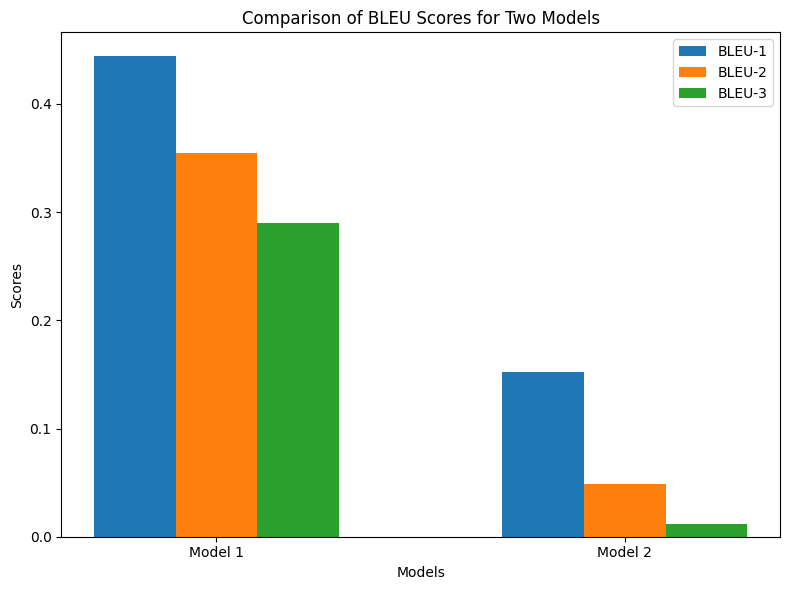

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for both models
models = ['Model 1', 'Model 2']
bleu_1 = [bleu_1, Blip_bleu_1]
bleu_2 = [bleu_2, Blip_bleu_2]
bleu_3 = [bleu_3, Blip_bleu_3]

# Bar width
bar_width = 0.2
index = np.arange(len(models))

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Bar positions
bar1 = ax.bar(index - bar_width, bleu_1, bar_width, label='BLEU-1')
bar2 = ax.bar(index, bleu_2, bar_width, label='BLEU-2')
bar3 = ax.bar(index + bar_width, bleu_3, bar_width, label='BLEU-3')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of BLEU Scores for Two Models')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


Generated Caption:
 BLIP: two young girls playing on a playground VS Custom Model:two little girls in pink are in a playground . 


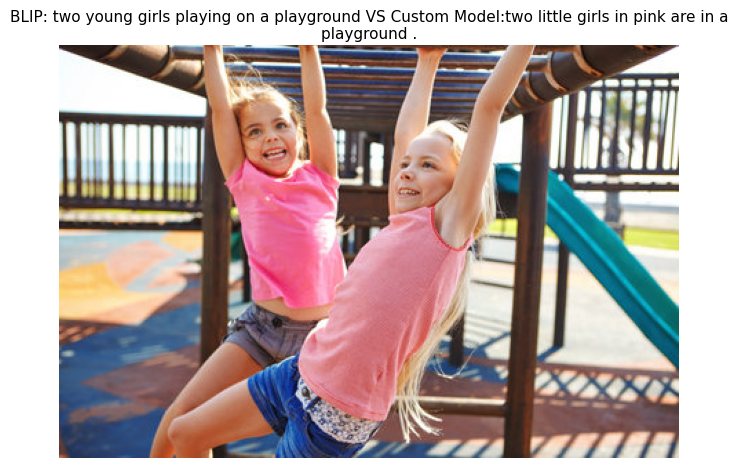

In [35]:

import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# 1. Preprocess the input image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to 224x224
        transforms.ToTensor(),  # Convert the image to a tensor
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

    # Move the image tensor to the same device as the model
    image = image.to(device)

    return image

# Function for top-p (nucleus) sampling
def top_p_sampling(probabilities, p=0.7):  # Reduce p for more diversity
    # Sort the probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)

    # Calculate the cumulative probabilities
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    # Get the cutoff index where the cumulative probability exceeds p
    cutoff_index = torch.where(cumulative_probs >= p)[0][0]

    # Only keep tokens up to the cutoff index
    top_p_probs = sorted_probs[:cutoff_index + 1]
    top_p_indices = sorted_indices[:cutoff_index + 1]

    # Sample from the remaining tokens
    sampled_token = torch.multinomial(top_p_probs, 1).item()
    return top_p_indices[sampled_token]

# Function for generating captions
def generate_caption(image_path, model, vocab, device, max_length=50, temperature=3.0, top_k=50, p=0.7):
    # Preprocess the image
    image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Start the caption generation with the <SOS> token
    caption = [vocab.stoi["<SOS>"]]  # Start with <SOS> token

    with torch.no_grad():
        for _ in range(max_length):
            # Create tensor for the caption tokens
            caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # (1, seq_len)

            # Extract image features using the encoder
            features = model.encoder(image)

            # Forward pass through the decoder
            outputs, _, _ = model.decoder(caption_tensor, features)

            # Apply temperature to the logits for sampling
            logits = outputs[:, -1, :] / temperature
            probabilities = F.softmax(logits, dim=-1)

            # Use top-k sampling or top-p sampling
            if top_k > 0:
                topk_values, topk_indices = torch.topk(probabilities, top_k, dim=-1)
                topk_values = topk_values.squeeze(0)  # Remove the batch dimension
                topk_indices = topk_indices.squeeze(0)  # Remove the batch dimension
                # Convert topk_values to float for multinomial
                predicted_token = topk_indices[torch.multinomial(topk_values.float(), 1)].item()
            else:
                # Use top-p sampling
                predicted_token = top_p_sampling(probabilities.squeeze(0), p)

            # Append the predicted token to the caption
            caption.append(predicted_token)

            # If the model predicts <EOS> (end-of-sequence), stop generating
            if predicted_token == vocab.stoi["<EOS>"]:
                break

    # Convert token IDs to words using vocab
    caption_words = [vocab.itos[token] for token in caption[1:-1]]  # Skip <SOS> and <EOS>
    return ' '.join(caption_words)


# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Choose device (GPU or CPU)
image_path = '/content/drive/MyDrive/imagetest.jpg'  # Path to your image
image = Image.open(image_path).convert("RGB")

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('/content/drive/MyDrive/image_captioning_model_full1.pt', map_location=device)
model = model.to(device)

# Generate the caption
caption1 = generate_caption(image_path, model, dataset.vocab, device, temperature=3.0, top_k=50, p=0.7)


# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Generate the caption
output2 = model2.generate(**inputs)
caption2 = processor.decode(output2[0], skip_special_tokens=True)

print(f"Generated Caption:\n BLIP: {caption2} VS Custom Model:{caption1} ")
# Plot the image with the caption
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")  # Turn off axis
plt.title(f"BLIP: {caption2} VS Custom Model:{caption1}", fontsize=11, wrap=True)  # Display caption
plt.show()

---

## Author

**MEDPRG**  
[GitHub Profile](https://github.com/MEDPRG)